# Pylops-distributed - derivatives

In this notebook I will show how to perform derivatives in *Pylops-distributed*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from scipy.signal import triang
from scipy.sparse.linalg import lsqr
from pylops.utils import dottest
from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

Local cluster

In [2]:
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=2,
                                               n_workers=2)
client

Client Scheduler: inproc://10.0.0.87/9120/1 Dashboard: http://localhost:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.59 GB


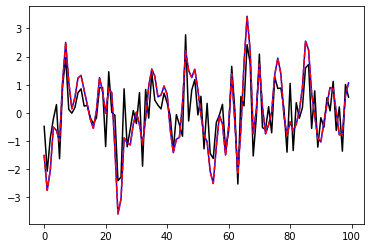

In [3]:
n = 100
nchunks = 10
sampling = 1

#x = np.zeros(n)
#x[n//2] = 1
x = np.random.normal(0, 1, n)
xd = da.from_array(x, chunks=n//nchunks)

h = np.array([0.5, 1, 0.5]) / sampling

y = np.convolve(x, h, mode='same')
yd = da.map_overlap(xd, lambda x: np.convolve(x, h, mode='same'), depth=1, 
                    boundary=0, trim=True)
yd = yd.compute()

plt.figure()
plt.plot(x, 'k')
plt.plot(y, 'b')
plt.plot(yd, '--r')

In [4]:
# filters
nfilt = (5, 6, 5)
h1 = triang(nfilt[0], sym=True)
h2 = np.outer(triang(nfilt[0], sym=True), triang(nfilt[1], sym=True))
h3 = np.outer(np.outer(triang(nfilt[0], sym=True), triang(nfilt[1], sym=True)),
              triang(nfilt[2], sym=True)).reshape(nfilt)

par = {'nz': 21, 'ny': 31, 'nx': 31, 'offset': nfilt[0] // 2,
       'dir': 1}  # zero phase, first direction
#par = {'nz': 21, 'ny': 61, 'nx': 31, 'offset': 0,
#       'dir': 0}  # non-zero phase, first direction
np.random.seed(10)

Cop = pylops.signalprocessing.Convolve1D(par['ny'] * par['nx'], h=h1, offset=par['offset'],
                        dims=(par['ny'], par['nx']), dir=par['dir'],
                        dtype='float32')
dCop = pylops_distributed.signalprocessing.Convolve1D(par['ny'] * par['nx'], h=h1, offset=par['offset'],
                                      dims=(par['ny'], par['nx']), dir=par['dir'],
                                      compute=(True, True),
                                      chunks=((par['ny'] // 2 + 1, par['nx'] // 2 + 1),
                                              (par['ny'] // 2 + 1, par['nx'] // 2 + 1)),
                                      dtype='float32')

x = np.random.normal(0., 1., (par['ny'], par['nx']))
dx = da.from_array(x, chunks=(par['ny'] // 2 + 1, par['nx'] // 2 + 1))
dy = dCop * dx.ravel()
y = Cop * x.ravel()

here!!
<class 'dask.array.core.Array'>
here matvec
dask.array<reshape, shape=(961,), dtype=float64, chunksize=(248,)>


In [5]:
from scipy.signal import convolve, fftconvolve

dx = dx.rechunk((par['ny'] // 2 + 1, par['nx'] // 2 + 1))

dy1 = da.map_overlap(dx, lambda x: fftconvolve(x, h1[np.newaxis, :], mode='same', axes=1),
                     depth=(1, 2), boundary=0, trim=True)
dy1 = dy1.reshape(par['ny'], par['nx'])

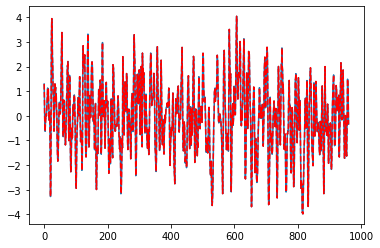

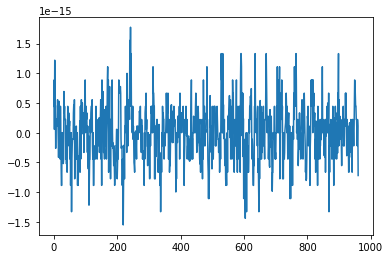

In [6]:
plt.figure()
plt.plot(y)
plt.plot(dy, '--r')

plt.figure()
plt.plot(y-dy)

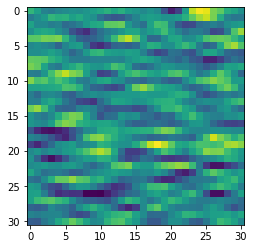

In [7]:
plt.imshow(y.reshape(par['ny'], par['nx']))

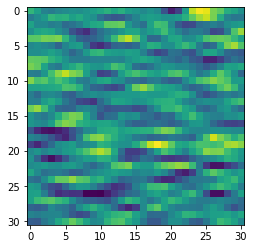

In [8]:
plt.imshow(dy.reshape(par['ny'], par['nx']))

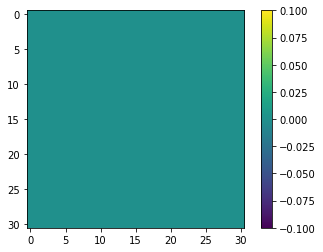

In [9]:
plt.imshow(dy1.reshape(par['ny'], par['nx']) - dy.reshape(par['ny'], par['nx']))
plt.colorbar()

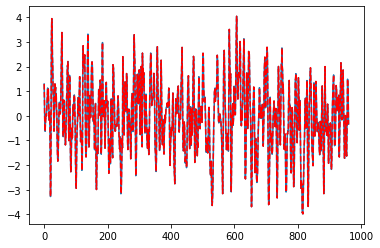

In [10]:
plt.figure()
plt.plot(dy)
plt.plot(dy1.ravel(), '--r')